# Aprendizado Profundo (Ext. Artibutos RP) - Fine tuning

Estruturação de pipeline baseado em aprendizado raso utilizando atributos extraídos via Deep Learning dos RPs.


# Configurações

In [1]:
import os
import sys
import gc
import json
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

from tqdm import *

from pretty_confusion_matrix import *

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS
RESIDENCIA = 3

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "27") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")
caminho_ukdale = os.path.join(caminho_dados, "UK-DALE")

# Path completo do arquivo REDD/UKDALE
arquivo_dataset_redd = os.path.join(caminho_redd, "redd.h5")
arquivo_dataset_ukdale = os.path.join(caminho_ukdale, "ukdale.h5")

# # VARIAVEL AUXILIAR
# # Path dos arquivos relacionados as janelas
# caminho_janelas = os.path.join(caminho_redd, "../../phd")
# if not os.path.isdir(caminho_janelas):
#     os.makedirs(caminho_janelas)

In [3]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline

# Dados

## Base REDD

In [4]:
# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset_redd):
    from nilmtk.dataset_converters import convert_redd
    
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset_redd)

# Carregando dataset REDD no objeto NILMTK
# Exemplo de carregamento da base REDD no NILMTK
import h5py # * Evitar erro de incompatibilidade entre h5py e nilmtk
from nilmtk import DataSet
from nilmtk.utils import print_dict

redd = DataSet(arquivo_dataset_redd)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)
print()

NILMTK -> Detalhes sobre o dataset REDD:


## UK-DALE

In [5]:
ukdale = DataSet(arquivo_dataset_ukdale)
print("NILMTK -> Detalhes sobre o dataset UK-DALE:")
print_dict(ukdale.metadata)
print()

NILMTK -> Detalhes sobre o dataset UK-DALE:


In [6]:
from datetime import datetime, timedelta
from dateutil.parser import parse as date_parser

date_parser(ukdale.metadata['timeframe']['start'])

datetime.datetime(2012, 11, 9, 22, 28, 15, tzinfo=tzutc())

In [7]:
date_parser(ukdale.metadata['timeframe']['end'])

datetime.datetime(2015, 1, 5, 6, 26, 44, tzinfo=tzutc())

In [8]:
(date_parser(ukdale.metadata['timeframe']['start']) + timedelta(days=30)).strftime('%Y-%m-%d')

'2012-12-09'

## Melhores Combinações de Taxas e Janelas para cada Aparelho (estudo 19)

In [9]:
df_melhores_taxas_janelas = pd.read_csv(os.path.join(caminho_dados, "19", "melhores_taxa_janela_aparelhos.csv"), index_col=0)
df_melhores_taxas_janelas

,carga,taxa_amostragem,janela,loss,acuracia,precisao,recall,f1,f1_macro
0,dish_washer - 9,2,720,0.05,95.33,20.00,25.00,22.22,59.91
1,fridge - 7,2,1080,0.00,100.00,100.00,100.00,100.00,100.00
2,microwave - 16,2,900,0.04,95.83,66.67,33.33,44.44,71.14
3,washer_dryer - 13,2,60,0.00,99.89,100.00,95.74,97.83,98.88
4,washer_dryer - 14,3,360,0.02,97.99,100.00,55.56,71.43,85.19


In [10]:
# TODO: 
# - Desenvolver módulo da metodologia na lib PyNILM 

## Parâmetros de RP dos Aparelhos (estudo 18)

In [11]:
# Carregando arquivos de parametros, caso n estejam (kernel reiniciado)
if not 'parametros_rp_aparelho' in locals():
    with open(os.path.join(caminho_dados, "18", "parametros_rp_aparelho.json"),'r') as arquivo:
        parametros_rp_aparelho = json.load(arquivo)

## Ambiente e Funções Auxiliares

In [12]:
# from PyNILM.dados.janelas import Janelas
from PyNILM.dados.janelas import Janelas
from PyNILM.dados.utils import *

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from PyNILM.modelos.utils import *
from PyNILM.modelos.dlafe import DLAFE
from PyNILM.modelos.rqa import RQA

# Inicializar uso GPU
start_tf_session(memory_limit=int(1024*4))

Virtual devices cannot be modified after being initialized


## Configurações do Experimento

In [13]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Teste da classe
# janelas_treino = Janelas(
#     base=DataSet(arquivo_dataset_redd),
#     id_residencia=3,
#     inicio_intervalo='2011-04-16',
#     fim_intervalo='2011-05-16',
#     debug = False
# )
data_inicio_treino = date_parser(ukdale.metadata['timeframe']['start']).strftime('%Y-%m-%d %H:%M:%S')
periodo = 30 # periodo amostral
data_fim_treino = (date_parser(ukdale.metadata['timeframe']['start']) + timedelta(days=periodo)).strftime('%Y-%m-%d %H:%M:%S')
print('Período de treino (base UK-DALE):', data_inicio_treino, 'a', data_fim_treino)

janelas_treino = Janelas(
    base=DataSet(arquivo_dataset_ukdale),
    id_residencia=3,
    inicio_intervalo=data_inicio_treino,
    fim_intervalo=data_fim_treino,
    debug = True
)

janelas_teste = Janelas(
    base=DataSet(arquivo_dataset_redd),
    id_residencia=3,
    inicio_intervalo='2011-05-17 00:00:00',
    fim_intervalo='2011-05-30 23:59:59',
    debug = False
)

aparelhos = [
    'dish_washer - 9',
    'fridge - 7',
    'microwave - 16',
    'washer_dryer - 13', 
    'washer_dryer - 14'
]

TAXA = 2 # Fixa

modelo_extrator = transfer_learning.vgg16.VGG16(
            weights='imagenet', 
            include_top=False,
            pooling='avg'
        )
preprocessamento_extrator = transfer_learning.vgg16.preprocess_input

Período de treino (base UK-DALE): 2012-11-09 22:28:15 a 2012-12-09 22:28:15


In [14]:
# https://notebook.community/jaduimstra/nilmtk/docs/manual/user_guide/elecmeter_and_metergroup

In [88]:
def carregar_dados(base, taxa_amostral=2, periodo=30, residencias=None, aparelhos=None, janelas=None, debug=False):
    """
    Função para carregar e preparar as janelas de consumo e ativações dos aparelhos em diferentes residenciais de um dataset.

    Retorno:
        dados (list): lista com as informações (janelas e metadados) dos aparelhos de interesse.
    """
    dados = []

    for r in base.buildings:
        
        if residencias and r not in residencias:
            continue

        if debug: print(f"> Processando residência #{r}...")
        
        # dados[b] = {
        #     'medidores': [],
        #     'aparelhos': []

        # }

        # Consumo agregado da residencia (serie historica)
        # if debug: print("* Extraindo dados de consumo agregado da residencia...")
        consumo_agregado = carregar_dados_consumo_agregado(
            base, taxa_amostral=taxa_amostral, residencia=r, debug=debug)
        indices_agregado = consumo_agregado.index.to_pydatetime()
        if debug: print(f'  - Consumo agregado: de', consumo_agregado.index[0], 'a', consumo_agregado.index[-1])

        residencia = base.buildings[r]

        # Gerar janelas para cada canal/aparelho
        if debug: print("* Gerando janelas para cada canal/aparelho...")

        # inicio_intervalo =  datetime.strptime(inicio_intervalo, '%Y-%m-%d %H:%M:%S').date()
        # fim_intervalo = datetime.strptime(fim_intervalo, '%Y-%m-%d %H:%M:%S').date()
        if debug: print('Residencia:', residencia)
        
        for e in residencia.elec.all_meters():

            # Selecionando canal/aparelho
            # e = self.residencia.elec[e_i]

            # Normalizar nome aparelho/canal de medicao
            aparelho = e.label().lower().replace(" ", "_")

            if not any(map(aparelho.__contains__, aparelhos.keys())) or 'site_meter' in aparelho:
                continue

            tamanho_janela = 1080
            if aparelhos:
                for k, v in aparelhos.items():
                    if k in aparelho:
                        tamanho_janela = v
                        break

            try:

                # # Extraindo medicoes de energia da carga
                # power = np.array(e.power_series_all_data(sample_period=taxa_amostral).values[:limite_serie])
                
                # Extraindo medicoes de energia da carga (toda a serie)
                consumo_aparelho = e.power_series_all_data(sample_period=taxa_amostral).replace(np.nan, 0) # Remover nan (por zero)

                # Definindo periodo/janela de analise (consumo individual e agregado)
                if aparelho not in 'site_meter':
                    inicio_periodo = consumo_aparelho.index[0]
                    fim_periodo = consumo_aparelho.index[0] + timedelta(days=periodo)
                    
                    # Selecionando periodo no consumo do aparelho
                    indices_aparelho = consumo_aparelho.index.to_pydatetime()
                    consumo_aparelho = consumo_aparelho[(indices_aparelho >= inicio_periodo) & (indices_aparelho <= fim_periodo)]
                    if debug: print(f'Consumo aparelho {aparelho}: de', consumo_aparelho.index[0], 'a', consumo_aparelho.index[-1], 
                                '|', consumo_aparelho.shape, 
                                '>>>', consumo_agregado.values.min(), consumo_agregado.values.max(),
                                    consumo_agregado.values.mean(), consumo_agregado.values.std())

                    # Selecionando periodo no consumo agregado (mesmo range de analise para as janelas)
                    consumo_agregado_aparelho = consumo_agregado[(indices_agregado >= inicio_periodo) & (indices_agregado <= fim_periodo)]
                    if debug: 
                        print(f'  - Consumo agregado/aparelho: de ', consumo_agregado_aparelho.index[0], 'a', consumo_agregado_aparelho.index[-1],
                                '|', consumo_agregado_aparelho.shape, 
                                '>>>', consumo_agregado_aparelho.values.min(), consumo_agregado_aparelho.values.max(),
                                    consumo_agregado_aparelho.values.mean(), consumo_agregado_aparelho.values.std())
                        print(f'  - Shapes sincronizados?', consumo_agregado_aparelho.shape == consumo_aparelho.shape)

                    # print(' -', aparelho, '=', inicio_periodo, 'a', fim_periodo, '|', tamanho_janela )

                    # TODO: dividir em janelas com indices -> np.array_split(dados, dados.shape[0] // (720 - 1))
                    
                    # Calculando tamanho máximo da série (padding, dependendo tamanho janeka)
                    limite_serie = int(len(consumo_aparelho.values) / tamanho_janela) * tamanho_janela

                    # Garantindo limite da serie valido (caber dentro do reshape do tamanho janela)
                    while limite_serie % tamanho_janela != 0:
                        limite_serie -= 1
                    
                    # Encaixando medicao dentro do tamanho de janelas (p/ fazer reshape)
                    # power = power.values[:limite_serie]
                    consumo_aparelho = consumo_aparelho.iloc[:limite_serie]
                    consumo_agregado_aparelho = consumo_agregado_aparelho.iloc[:limite_serie]

                    # Gerando máscara de status (ativo ou não), considerando ruido da carga
                    # ou rede na medição (threshod)
                    # status = power > e.on_power_threshold()
                    ativacoes = (consumo_aparelho >= e.on_power_threshold()).astype(int)

                    # # Dividindo em janelas (consumo energetico individual e agregado, bem como ativacoes)
                    # windows_series = power.reshape(-1, tamanho_janela)
                    # windows_status = status.reshape(-1, tamanho_janela)
                    # janelas_aparelho = np.array_split(consumo_aparelho, consumo_aparelho.shape[0] // (tamanho_janela - 1))
                    janelas_consumo_aparelho = np.vstack(
                        np.array_split(
                            consumo_aparelho, 
                            consumo_aparelho.shape[0] // tamanho_janela
                        )
                    )
                    janelas_agregado_aparelho = np.vstack(
                        np.array_split(
                            consumo_agregado_aparelho, 
                            consumo_agregado_aparelho.shape[0] // tamanho_janela
                        )
                    )
                    janelas_ativacoes = np.vstack(
                        np.array_split(
                            ativacoes, 
                            ativacoes.shape[0] // tamanho_janela
                            )
                    )

                    # # # Remover nan (por zero)
                    # # windows_series = np.nan_to_num(windows_series)

                    # # Extraindo ativacoes
                    # windows_status = np.where(
                    #     np.sum(windows_status, axis=1) > 0, 1, 0
                    # )  # Estado de cada janela, baseado na pré-avaliação da serie
                    ativacao_por_janela = []
                    for w in janelas_ativacoes:
                        ativacao_por_janela.append(1 if w.sum() > 0 else 0)
                    

                    # #     # Calcular rotulos a partir das janelas
                    # #     # Podendo ser:
                    # #     #   - `estado` (denotando carga ATIVA [1] ou INATIVA [0]);
                    # #     #   - `total`(soma da janela);
                    # #     #   - `media`;
                    # #     rotulos = {
                    # #         "total": np.sum(windows_series, axis=1),
                    # #         "media": np.mean(windows_series, axis=1),
                    # #         "estado": np.where(
                    # #             np.sum(windows_status, axis=1) > 0, 1, 0
                    # #         )  # Estado de cada janela, baseado na pré-avaliação da serie
                    # #         # completa, considerando ruido
                    # #     }

                    dados.append({
                        "aparelho": aparelho,
                        "instancia": e.instance(),
                        "residencia": r,
                        "janelas": janelas_agregado_aparelho,
                        "consumo": janelas_consumo_aparelho,
                        "status": np.array(ativacao_por_janela),
                        "estatisticas": {
                            "status": dict(Counter(ativacao_por_janela)),
                            # TODO: validar integridade das janelas (mesmo tamanho) e conversao das janelas para np.array (np.vstack)
                            "consumo_por_janela": {
                                "min": janelas_agregado_aparelho.sum(axis=1).min(),
                                "max": janelas_agregado_aparelho.sum(axis=1).max(),
                                "mean": janelas_agregado_aparelho.sum(axis=1).mean(),
                                "std": janelas_agregado_aparelho.sum(axis=1).std()
                            },
                            "consumo_historico_aparelho": {
                                "min": consumo_aparelho.min(),
                                "max": consumo_aparelho.max(),
                                "mean": consumo_aparelho.mean(),
                                "std": consumo_aparelho.std()
                            }
                        },
                        "metadata": e.metadata
                    })

                    # TODO: Sincronizar medidor e aparelho (indices)

                    #     if self.debug: print(f"{aparelho} -> {windows_series.shape}")

            except Exception as ex:
                if debug: print(f"{aparelho}-{e.instance()}: erro ao extrair dados -> {str(ex)}")
                # return {
                #         "aparelho": aparelho,
                #         "instancia": e.instance(),
                #         "residencia": r,
                #         "janelas": janelas_agregado_aparelho,
                #         "consumo": consumo_aparelho,
                #         "status": np.array(ativacao_por_janela)
                #         }
                
    return dados

def carregar_dados_consumo_agregado(base, taxa_amostral=2, residencia=1, debug=False):
    # Consumo agregado = potencia aparente
    # COnsumo individual = potencia ativa
    dados = []

    for b in base.buildings:
            
        if b != residencia:
            continue

        residencia = base.buildings[b]

        # Gerar janelas para cada canal/aparelho
        if debug: print("* Extraindo consumo agregado dos medidores...")

        # inicio_intervalo =  datetime.strptime(inicio_intervalo, '%Y-%m-%d %H:%M:%S').date()
        # fim_intervalo = datetime.strptime(fim_intervalo, '%Y-%m-%d %H:%M:%S').date()
        if debug: print('Residencia:', residencia)
        
        for e in residencia.elec.all_meters():

            # Selecionando canal/aparelho
            # e = self.residencia.elec[e_i]

            # Normalizar nome aparelho/canal de medicao
            aparelho = e.label().lower().replace(" ", "_")

            if aparelho != 'site_meter':
                continue

            try:

                # # Extraindo medicoes de energia da carga
                # power = np.array(e.power_series_all_data(sample_period=taxa_amostral).values[:limite_serie])
                
                # Extraindo medicoes de energia da carga (toda a serie)
                consumo = e.power_series_all_data(sample_period=taxa_amostral)

                # Remover nan (por zero)
                consumo = consumo.replace(np.nan, 0)

                dados.append({
                    "rotulo": aparelho,
                    "instancia": e.instance(),
                    "consumo": consumo
                })

            except Exception as e:
                if debug: print(f"{aparelho}: erro ao extrair dados -> {str(e)}")

    consumo_agregado = pd.concat([c['consumo'] for c in dados], axis=1).sum(1, min_count=1).fillna(0)

    return consumo_agregado

In [89]:
dados = carregar_dados(
    ukdale,  
    periodo=30,
    residencias=[2],
    aparelhos={
        #'microwave': 900, 
        #'dish': 720, 
        #'washer': 360, 
        'washing': 360, 
        #'fridge': 1080
        },
    debug=True
    )

> Processando residência #2...
* Extraindo consumo agregado dos medidores...
Residencia: Building(instance=2, dataset='UK-DALE')
  - Consumo agregado: de 2013-02-17 16:17:34+00:00 a 2013-10-10 06:16:00+01:00
* Gerando janelas para cada canal/aparelho...
Residencia: Building(instance=2, dataset='UK-DALE')
Consumo aparelho washing_machine: de 2013-05-20 22:28:38+01:00 a 2013-06-19 22:28:38+01:00 | (1296001,) >>> 0.0 16529.0 465.20947 785.4045
  - Consumo agregado/aparelho: de  2013-05-20 22:28:38+01:00 a 2013-06-19 22:28:38+01:00 | (1296001,) >>> 0.0 12120.01 592.56226 947.03033
  - Shapes sincronizados? True


In [81]:
dados

[{'aparelho': 'washing_machine',
  'instancia': 12,
  'residencia': 2,
  'janelas': [2013-05-20 22:28:38+01:00    487.045013
   2013-05-20 22:28:40+01:00    488.549988
   2013-05-20 22:28:42+01:00    489.035004
   2013-05-20 22:28:44+01:00    493.549988
   2013-05-20 22:28:46+01:00    488.899994
                                   ...    
   2013-05-20 22:40:28+01:00    459.535004
   2013-05-20 22:40:30+01:00    458.290009
   2013-05-20 22:40:32+01:00    450.975006
   2013-05-20 22:40:34+01:00    453.600006
   2013-05-20 22:40:36+01:00    451.864990
   Freq: 2S, Length: 360, dtype: float32,
   2013-05-20 22:40:38+01:00    451.679993
   2013-05-20 22:40:40+01:00    452.750000
   2013-05-20 22:40:42+01:00    456.850006
   2013-05-20 22:40:44+01:00    465.339996
   2013-05-20 22:40:46+01:00    460.600006
                                   ...    
   2013-05-20 22:52:28+01:00    908.859985
   2013-05-20 22:52:30+01:00    908.270020
   2013-05-20 22:52:32+01:00    905.799988
   2013-05-20 22

In [87]:
np.vstack(dados[0]["janelas"]).sum(axis=1)

array([238889.66, 218274.67, 295658.34, ..., 112120.69,  86336.85,
       102028.91], dtype=float32)

In [69]:
Counter([j.shape[0] for j  in dados[0]['janelas']])

Counter({360: 10, 359: 3600})

In [70]:
Counter([j.shape[0] for j  in dados[0]['consumo']])

AttributeError: 'float' object has no attribute 'shape'

In [77]:
janelas = np.array_split(
    dados[0]['consumo'], 
    dados[0]['consumo'].shape[0] // 360
)
janelas

[2013-05-20 22:28:38+01:00    3.0
 2013-05-20 22:28:40+01:00    3.0
 2013-05-20 22:28:42+01:00    3.0
 2013-05-20 22:28:44+01:00    3.0
 2013-05-20 22:28:46+01:00    3.0
                             ... 
 2013-05-20 22:40:28+01:00    3.0
 2013-05-20 22:40:30+01:00    3.0
 2013-05-20 22:40:32+01:00    3.0
 2013-05-20 22:40:34+01:00    3.0
 2013-05-20 22:40:36+01:00    3.0
 Freq: 2S, Name: (power, active), Length: 360, dtype: float32,
 2013-05-20 22:40:38+01:00    3.0
 2013-05-20 22:40:40+01:00    3.0
 2013-05-20 22:40:42+01:00    3.0
 2013-05-20 22:40:44+01:00    3.0
 2013-05-20 22:40:46+01:00    3.0
                             ... 
 2013-05-20 22:52:28+01:00    4.0
 2013-05-20 22:52:30+01:00    4.0
 2013-05-20 22:52:32+01:00    4.0
 2013-05-20 22:52:34+01:00    3.0
 2013-05-20 22:52:36+01:00    3.0
 Freq: 2S, Name: (power, active), Length: 360, dtype: float32,
 2013-05-20 22:52:38+01:00    3.0
 2013-05-20 22:52:40+01:00    3.0
 2013-05-20 22:52:42+01:00    3.0
 2013-05-20 22:52:44+01:

In [78]:
Counter([j.shape[0] for j  in janelas])

Counter({360: 3600})

In [35]:
{
"status": dict(Counter(dados["status"])),
"consumo_energetico": {
    "min": dados["consumo"].min(),
    # "max": np.max(consumo_aparelho, axis=1),
    # "mean": np.mean(consumo_aparelho, axis=1),
    # "std": np.std(consumo_aparelho, axis=1)
}
}

{'status': {0: 3547, 1: 63}, 'consumo_energetico': {'min': 0.0}}

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 360 and the array at index 10 has size 359

In [25]:
dados.power_series_all_data(sample_period=2).replace(np.nan, 0)

2013-05-20 22:28:38+01:00    3.0
2013-05-20 22:28:40+01:00    3.0
2013-05-20 22:28:42+01:00    3.0
2013-05-20 22:28:44+01:00    3.0
2013-05-20 22:28:46+01:00    3.0
                            ... 
2013-10-10 06:15:12+01:00    4.0
2013-10-10 06:15:14+01:00    4.0
2013-10-10 06:15:16+01:00    4.0
2013-10-10 06:15:18+01:00    4.0
2013-10-10 06:15:20+01:00    4.0
Freq: 2S, Name: (power, active), Length: 6148402, dtype: float32

In [233]:
consumo_agregado = carregar_dados_consumo_agregado(ukdale, taxa_amostral=2, residencia=1, debug=True)

* Extraindo consumo agregado dos medidores...
Residencia: Building(instance=1, dataset='UK-DALE')


In [261]:
consumo_agregado.values.mean()

613.57794

In [257]:
type(consumo_agregado.index[0])

Timestamp('2012-11-09 22:28:14+0000', tz='Europe/London', freq='2S')

In [259]:
np.array([pd.to_datetime(i) for i in consumo_agregado.index])

[Timestamp('2012-11-09 22:28:14+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:16+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:18+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:20+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:22+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:24+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:26+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:28+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:30+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:32+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:34+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:36+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:38+0000', tz='Europe/London', freq='2S'),
 Timestamp('2012-11-09 22:28:40+0000', tz='Europe/London', freq='2S'),
 Times

In [249]:
indices_datetime = consumo_agregado.index.to_pydatetime()
indices_datetime

array([datetime.datetime(2012, 11, 9, 22, 28, 14, tzinfo=<DstTzInfo 'Europe/London' GMT0:00:00 STD>),
       datetime.datetime(2012, 11, 9, 22, 28, 16, tzinfo=<DstTzInfo 'Europe/London' GMT0:00:00 STD>),
       datetime.datetime(2012, 11, 9, 22, 28, 18, tzinfo=<DstTzInfo 'Europe/London' GMT0:00:00 STD>),
       ...,
       datetime.datetime(2015, 1, 5, 6, 27, 8, tzinfo=<DstTzInfo 'Europe/London' GMT0:00:00 STD>),
       datetime.datetime(2015, 1, 5, 6, 27, 10, tzinfo=<DstTzInfo 'Europe/London' GMT0:00:00 STD>),
       datetime.datetime(2015, 1, 5, 6, 27, 12, tzinfo=<DstTzInfo 'Europe/London' GMT0:00:00 STD>)],
      dtype=object)

In [250]:
indices_datetime[0]

datetime.datetime(2012, 11, 9, 22, 28, 14, tzinfo=<DstTzInfo 'Europe/London' GMT0:00:00 STD>)

In [251]:
indices_datetime[0] + timedelta(days=periodo)

datetime.datetime(2012, 12, 9, 22, 28, 14, tzinfo=<DstTzInfo 'Europe/London' GMT0:00:00 STD>)

In [154]:
for c in consumo_agregado:
    print(c['rotulo'], c['instancia'], '| de', c['consumo'].index[0], 'a', c['consumo'].index[-1])
    

site_meter 54 | de 2013-03-17 19:12:42+00:00 a 2015-01-05 06:27:12+00:00
site_meter 1 | de 2012-11-09 22:28:14+00:00 a 2015-01-05 06:15:46+00:00


In [160]:
# Observando ponto de interseccao dos medidores
interseccao_temporal = pd.Timestamp('2013-03-17 19:12:42+00:00')
consumo_agregado[0]['consumo'][
    consumo_agregado[0]['consumo'].index == interseccao_temporal
]

2013-03-17 19:12:42+00:00    337.880005
Freq: 2S, Name: (power, active), dtype: float32

In [159]:
consumo_agregado[1]['consumo'][
    consumo_agregado[1]['consumo'].index == interseccao_temporal
]

2013-03-17 19:12:42+00:00    420.0
Freq: 2S, Name: (power, apparent), dtype: float32

In [166]:
consumo_geral = pd.concat([c['consumo'] for c in consumo_agregado], axis=1).sum(1, min_count=1).fillna(0)

In [167]:
consumo_geral[
    consumo_geral.index == interseccao_temporal
]

2013-03-17 19:12:42+00:00    757.880005
Freq: 2S, dtype: float32

In [168]:
consumo_geral

2012-11-09 22:28:14+00:00    599.000000
2012-11-09 22:28:16+00:00    599.000000
2012-11-09 22:28:18+00:00    599.000000
2012-11-09 22:28:20+00:00    582.000000
2012-11-09 22:28:22+00:00    582.000000
                                ...    
2015-01-05 06:27:04+00:00    173.860001
2015-01-05 06:27:06+00:00    173.850006
2015-01-05 06:27:08+00:00    173.795013
2015-01-05 06:27:10+00:00    173.940002
2015-01-05 06:27:12+00:00    173.839996
Freq: 2S, Length: 33969570, dtype: float32

In [169]:
consumo_agregado[0]['consumo']

2013-03-17 19:12:42+00:00    337.880005
2013-03-17 19:12:44+00:00    340.029999
2013-03-17 19:12:46+00:00    339.839996
2013-03-17 19:12:48+00:00    339.479980
2013-03-17 19:12:50+00:00    339.349976
                                ...    
2015-01-05 06:27:04+00:00    173.860001
2015-01-05 06:27:06+00:00    173.850006
2015-01-05 06:27:08+00:00    173.795013
2015-01-05 06:27:10+00:00    173.940002
2015-01-05 06:27:12+00:00    173.839996
Freq: 2S, Name: (power, active), Length: 28445836, dtype: float32

In [170]:
consumo_agregado[1]['consumo']

2012-11-09 22:28:14+00:00    599.0
2012-11-09 22:28:16+00:00    599.0
2012-11-09 22:28:18+00:00    599.0
2012-11-09 22:28:20+00:00    582.0
2012-11-09 22:28:22+00:00    582.0
                             ...  
2015-01-05 06:15:38+00:00    201.0
2015-01-05 06:15:40+00:00    202.0
2015-01-05 06:15:42+00:00    202.0
2015-01-05 06:15:44+00:00    202.0
2015-01-05 06:15:46+00:00    203.0
Freq: 2S, Name: (power, apparent), Length: 33969227, dtype: float32

In [230]:
dados[2]['aparelhos'][0]

{'rotulo': 'washing_machine',
 'instancia': 12,
 'janelas': [2013-05-20 00:00:00+01:00    143.804993
  2013-05-20 00:00:02+01:00    144.945007
  2013-05-20 00:00:04+01:00    145.020004
  2013-05-20 00:00:06+01:00    144.684998
  2013-05-20 00:00:08+01:00    144.875000
                                  ...    
  2013-05-20 00:11:50+01:00    143.764999
  2013-05-20 00:11:52+01:00    143.979996
  2013-05-20 00:11:54+01:00    143.929993
  2013-05-20 00:11:56+01:00    144.070007
  2013-05-20 00:11:58+01:00    143.950012
  Freq: 2S, Length: 360, dtype: float32,
  2013-05-20 00:12:00+01:00    143.730011
  2013-05-20 00:12:02+01:00    143.660004
  2013-05-20 00:12:04+01:00    143.904999
  2013-05-20 00:12:06+01:00    143.744995
  2013-05-20 00:12:08+01:00    144.295013
                                  ...    
  2013-05-20 00:23:50+01:00    228.320007
  2013-05-20 00:23:52+01:00    228.410004
  2013-05-20 00:23:54+01:00    227.789993
  2013-05-20 00:23:56+01:00    227.410004
  2013-05-20 00:23

In [227]:
len(dados[2]['aparelhos'][0]['janelas'])

3617

In [228]:
len(dados[2]['aparelhos'][0]['status'])

3617

In [229]:
Counter(dados[2]['aparelhos'][0]['status'])

Counter({0: 3554, 1: 63})

In [81]:
# janelas = np.array_split(dados, dados.shape[0] // (720 - 1))

In [82]:
len(janelas)

1821

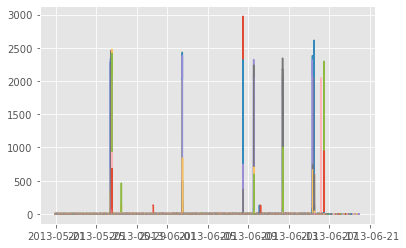

In [144]:
for j in dados[2]['aparelhos'][0]['janelas']:
    plt.plot(j)

In [ ]:
# TODO: preprar dados -> sincronizar periodo do consumo agregado com as janelas dos aparelhos alvos

# Metodologia DLAFE

In [10]:
modelo_extrator = transfer_learning.vgg16.VGG16(
            weights='imagenet', 
            include_top=False,
            pooling='avg'
        )
preprocessamento_extrator = transfer_learning.vgg16.preprocess_input

## SVM

In [51]:
modelo = SVC(kernel='rbf', random_state=SEED)

resultados_modelo = {
    "appliance": [], "fold": [],
    "acc": [], "f1": [], "auc": [], 
    "base": []
}

for rotulo_aparelho in aparelhos:
    
    print(f"* Aparelho `{rotulo_aparelho}`...\n")
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])
    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAMANHO_JANELA = config_aparelho["janela"]

    #######################################################################
    #                AVALIACAO 1 - Base de treino / CV                    #
    #######################################################################
    # Extrair series divididas em janelas para cada medidor
    print("   - Base de TREINO\n")
    print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas_treino,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print("     -> Detalhes da amostragem (lotes):")
    print("     ---")
    for item in Counter(y).items():
        print(f"        - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    y_true, y_pred  = [], []

    print(f"     -> Avaliando modelo (CV - {skf.n_splits} folds)...\n")
    for it, (idx_treino, idx_teste) in tqdm_notebook(enumerate(skf.split(X, y)), total=skf.n_splits):

        # Preparando lotes
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]

        # Treinando modelo
        dlafe = DLAFE(
            feature_extractor=modelo_extrator,
            preprocess_input=preprocessamento_extrator,
            classifier=clone(modelo),
            rp_params = PARAMETROS_RP,
            input_shape = TAMANHO_IMAGEM_DLAFE,
            normalize=False
        )
        dlafe.fit(X_treino, y_treino)

        # Prevendo conjunto de teste
        y_hat = dlafe.predict(X_teste)

        # Incrementando resultados
        resultados_modelo["appliance"].append(rotulo_aparelho)
        resultados_modelo["fold"].append(it+1)
        resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
        resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
        resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
        resultados_modelo["base"].append("treino")
        
        reset_tf_session(model_name='dlafe')

        # Extendendo rotulos (analise global)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)
        
    #######################################################################
    #                 AVALIACAO 2 - Base de teste / CV                    #
    #######################################################################
    print("   - Base de TESTE\n")
    print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))

    # Avaliar na base de teste
    X_teste, y_teste = carregar_dados_aparelho(
        janelas=janelas_teste,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    
    print("     -> Detalhes da amostragem (lotes):")
    print("     ---")
    for item in Counter(y_teste).items():
        print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_teste)*100,1)}%)" )
    print()

    # Treinando modelo
    dlafe = DLAFE(
        feature_extractor=modelo_extrator,
        preprocess_input=preprocessamento_extrator,
        classifier=clone(modelo),
        rp_params = PARAMETROS_RP,
        input_shape = TAMANHO_IMAGEM_DLAFE,
        normalize=False
    )
    dlafe.fit(X, y)

    # Prevendo conjunto de teste
    y_hat = dlafe.predict(X_teste)

    # Incrementando resultados
    resultados_modelo["appliance"].append(rotulo_aparelho)
    resultados_modelo["fold"].append(it+1)
    resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
    resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
    resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
    resultados_modelo["base"].append("teste")
    
    reset_tf_session(model_name='dlafe')
    
    print()
    print("   - Final Results:")
    print("   ---")
    print()
    
    print("***** TRAIN *****")
    print("      -> Classification Report:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_true, y_pred))
    print()
    
    print("***** TEST *****")
    print("      -> Classification Report:")
    print()
    print(classification_report(y_teste, y_hat))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_teste, y_hat))
    print()
    
# Consolidating DataFrame
df_resultados = pd.DataFrame(resultados_modelo)
df_resultados.to_excel(os.path.join(caminho_dados_notebook, "df_resultados_svm.xlsx"))
    
print("############################## FINAL MODEL RESULTS ##############################")
display(df_resultados.groupby(["appliance","base"]).agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    "auc": ["mean", "std", "max", "min"]
}))

* Aparelho `dish_washer - 9`...

   - Base de TREINO

     -> Carregando dados (taxa=2, janela=720)...


ValueError: time data '2012-11-09' does not match format '%Y-%m-%d %H:%M:%S'

## XGBOOST

In [12]:
def pos_weight(y):
    try:
        counter = Counter(y)
        return counter[0]/counter[1]
    except:
        return 1

In [13]:
modelo = XGBClassifier(random_state=SEED, n_jobs=4)

resultados_modelo = {
    "appliance": [], "fold": [],
    "acc": [], "f1": [], "auc": [], 
    "base": []
}

for rotulo_aparelho in aparelhos:
    
    print(f"* Aparelho `{rotulo_aparelho}`...\n")
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])
    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAMANHO_JANELA = config_aparelho["janela"]

    #######################################################################
    #                AVALIACAO 1 - Base de treino / CV                    #
    #######################################################################
    # Extrair series divididas em janelas para cada medidor
    print("   - Base de TREINO\n")
    print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas_treino,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print("     -> Detalhes da amostragem (lotes):")
    print("     ---")
    for item in Counter(y).items():
        print(f"        - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    y_true, y_pred  = [], []

    print(f"     -> Avaliando modelo (CV - {skf.n_splits} folds)...\n")
    for it, (idx_treino, idx_teste) in tqdm_notebook(enumerate(skf.split(X, y)), total=skf.n_splits):

        # Preparando lotes
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]

        # Treinando modelo
        dlafe = DLAFE(
            feature_extractor=modelo_extrator,
            preprocess_input=preprocessamento_extrator,
            classifier=clone(modelo),#.set_params(**{'scale_pos_weight': pos_weight(y)}),
            rp_params = PARAMETROS_RP,
            input_shape = TAMANHO_IMAGEM_DLAFE,
            normalize=False
        )
        dlafe.fit(X_treino, y_treino)

        # Prevendo conjunto de teste
        y_hat = dlafe.predict(X_teste)

        # Incrementando resultados
        resultados_modelo["appliance"].append(rotulo_aparelho)
        resultados_modelo["fold"].append(it+1)
        resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
        resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
        resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
        resultados_modelo["base"].append("treino")
        
        reset_tf_session(model_name='dlafe')

        # Extendendo rotulos (analise global)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)
        
    #######################################################################
    #                 AVALIACAO 2 - Base de teste / CV                    #
    #######################################################################
    print("   - Base de TESTE\n")
    print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))

    # Avaliar na base de teste
    X_teste, y_teste = carregar_dados_aparelho(
        janelas=janelas_teste,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    
    print("     -> Detalhes da amostragem (lotes):")
    print("     ---")
    for item in Counter(y_teste).items():
        print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_teste)*100,1)}%)" )
    print()

    # Treinando modelo
    dlafe = DLAFE(
        feature_extractor=modelo_extrator,
        preprocess_input=preprocessamento_extrator,
        classifier=clone(modelo),#.set_params(**{'scale_pos_weight': pos_weight(y)}),
        rp_params = PARAMETROS_RP,
        input_shape = TAMANHO_IMAGEM_DLAFE,
        normalize=False
    )
    dlafe.fit(X, y)

    # Prevendo conjunto de teste
    y_hat = dlafe.predict(X_teste)

    # Incrementando resultados
    resultados_modelo["appliance"].append(rotulo_aparelho)
    resultados_modelo["fold"].append(it+1)
    resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
    resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
    resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
    resultados_modelo["base"].append("teste")
    
    reset_tf_session(model_name='dlafe')
    
    print()
    print("   - Final Results:")
    print("   ---")
    print()
    
    print("***** TRAIN *****")
    print("      -> Classification Report:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_true, y_pred))
    print()
    
    print("***** TEST *****")
    print("      -> Classification Report:")
    print()
    print(classification_report(y_teste, y_hat))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_teste, y_hat))
    print()
    
    
# Consolidating DataFrame
df_resultados = pd.DataFrame(resultados_modelo)
df_resultados.to_excel(os.path.join(caminho_dados_notebook, "df_resultados_xgboost.xlsx"))
    
print("############################## FINAL MODEL RESULTS ##############################")
display(df_resultados.groupby(["appliance","base"]).agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    "auc": ["mean", "std", "max", "min"]
}))

* Aparelho `dish_washer - 9`...

   - Base de TREINO

     -> Carregando dados (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
        - Classe `0`: 623 amostras (97.5%)
        - Classe `1`: 16 amostras (2.5%)

     -> Avaliando modelo (CV - 10 folds)...



  0%|          | 0/10 [00:00<?, ?it/s]

[12:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Virtual devices cannot be modified after being initialized
[12:52:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Virtual devices cannot be modified after being initialized
[12:52:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

  0%|          | 0/10 [00:00<?, ?it/s]

[12:54:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Virtual devices cannot be modified after being initialized
[12:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Virtual devices cannot be modified after being initialized
[12:54:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

  0%|          | 0/10 [00:00<?, ?it/s]

[12:55:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Virtual devices cannot be modified after being initialized
[12:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Virtual devices cannot be modified after being initialized
[12:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

  0%|          | 0/10 [00:00<?, ?it/s]

[12:58:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Virtual devices cannot be modified after being initialized
[12:59:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Virtual devices cannot be modified after being initialized
[13:00:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

  0%|          | 0/10 [00:00<?, ?it/s]

[13:10:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Virtual devices cannot be modified after being initialized
[13:10:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Virtual devices cannot be modified after being initialized
[13:11:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

acc                                      f1  \
                              mean       std       max       min      mean   
appliance         base                                                       
dish_washer - 9   teste   0.968137       NaN  0.968137  0.968137  0.491905   
                  treino  0.973413  0.007508  0.984375  0.968750  0.493257   
fridge - 7        teste   0.981752       NaN  0.981752  0.981752  0.495396   
                  treino  0.995349  0.009806  1.000000  0.976744  0.898824   
microwave - 16    teste   0.960123       NaN  0.960123  0.960123  0.803751   
                  treino  0.955015  0.022662  1.000000  0.921569  0.701603   
washer_dryer - 13 teste   0.997725       NaN  0.997725  0.997725  0.984742   
                  treino  0.998408  0.000839  1.000000  0.997347  0.982962   
washer_dryer - 14 teste   0.987654       NaN  0.987654  0.987654  0.938601   
                  treino  0.987402  0.007607  1.000000  0.976378  0.905937   

                                                             auc            \
                               std       max       min      mean       std   
appliance         base                                                       
dish_washer - 9   teste        NaN  0.491905  0.491905  0.500000       NaN   
                  treino  0.001922  0.496063  0.492063  0.499206  0.002510   
fridge - 7        teste        NaN  0.495396  0.495396  0.500000       NaN   
                  treino  0.213299  1.000000  0.494118  0.500000  0.000000   
microwave - 16    teste        NaN  0.803751  0.803751  0.768464       NaN   
                  treino  0.178837  1.000000  0.479592  0.678189  0.167578   
washer_dryer - 13 teste        NaN  0.984742  0.984742  0.973851       NaN   
                  treino  0.009378  1.000000  0.969910  0.972817  0.018423   
washer_dryer - 14 teste        NaN  0.938601  0.938601  0.895833       NaN   
                  treino  0.066179  1.000000  0.779641  0.861257  0.089757   

                                              
                               max       min  
appliance         base                        
dish_washer - 9   teste   0.500000  0.500000  
                  treino  0.500000  0.492063  
fridge - 7        teste   0.500000  0.500000  
                  treino  0.500000  0.500000  
microwave - 16    teste   0.768464  0.768464  
                  treino  1.000000  0.479592  
washer_dryer - 13 teste   0.973851  0.973851  
                  treino  1.000000  0.944444  
washer_dryer - 14 teste   0.895833  0.895833  
                  treino  1.000000  0.700000

## MLP

In [14]:
def class_weight(y, debug=False):
    
    # Classes distribution
    neg, pos = np.bincount(y)
    total = neg + pos

    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.
    w_0 = (1 / neg)*(total)/2.0 
    w_1 = (1 / pos)*(total)/2.0

    class_weight = {0: w_0, 1: w_1}

    print('Weight for class 0: {:.2f}'.format(w_0))
    print('Weight for class 1: {:.2f}'.format(w_1))
    
    return class_weight

In [15]:
def mlp(
    input_shape=TAMANHO_IMAGEM_DLAFE,
    metrics=[
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ], 
    output_bias=None
):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = keras.Sequential([
      keras.layers.Dense(10, activation='relu', input_shape=input_shape),
      # keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=0.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics
    )

    return model

In [16]:
modelo = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(10,), random_state=SEED)

resultados_modelo = {
    "appliance": [], "fold": [],
    "acc": [], "f1": [], "auc": [], 
    "base": []
}

for rotulo_aparelho in aparelhos:
    
    print(f"* Aparelho `{rotulo_aparelho}`...\n")
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])
    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAMANHO_JANELA = config_aparelho["janela"]

    #######################################################################
    #                AVALIACAO 1 - Base de treino / CV                    #
    #######################################################################
    # Extrair series divididas em janelas para cada medidor
    print("   - Base de TREINO\n")
    print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X, y = carregar_dados_aparelho(
        janelas=janelas_treino,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print("     -> Detalhes da amostragem (lotes):")
    print("     ---")
    for item in Counter(y).items():
        print(f"        - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()
    
    y_true, y_pred  = [], []

    print(f"     -> Avaliando modelo (CV - {skf.n_splits} folds)...\n")
    for it, (idx_treino, idx_teste) in tqdm_notebook(enumerate(skf.split(X, y)), total=skf.n_splits):

        # Preparando lotes
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]

        # Treinando modelo
        dlafe = DLAFE(
            feature_extractor=modelo_extrator,
            preprocess_input=preprocessamento_extrator,
            classifier=clone(modelo),
            rp_params = PARAMETROS_RP,
            input_shape = TAMANHO_IMAGEM_DLAFE,
            normalize=False
        )
        dlafe.fit(X_treino, y_treino)

        # Prevendo conjunto de teste
        y_hat = dlafe.predict(X_teste)

        # Incrementando resultados
        resultados_modelo["appliance"].append(rotulo_aparelho)
        resultados_modelo["fold"].append(it+1)
        resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
        resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
        resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
        resultados_modelo["base"].append("treino")
        
        reset_tf_session(model_name='dlafe')

        # Extendendo rotulos (analise global)
        y_true.extend(y_teste)
        y_pred.extend(y_hat)
        
    #######################################################################
    #                 AVALIACAO 2 - Base de teste / CV                    #
    #######################################################################
    print("   - Base de TESTE\n")
    print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))

    # Avaliar na base de teste
    X_teste, y_teste = carregar_dados_aparelho(
        janelas=janelas_teste,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    
    print("     -> Detalhes da amostragem (lotes):")
    print("     ---")
    for item in Counter(y_teste).items():
        print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()

    # Treinando modelo
    dlafe = DLAFE(
        feature_extractor=modelo_extrator,
        preprocess_input=preprocessamento_extrator,
        classifier=clone(modelo),
        rp_params = PARAMETROS_RP,
        input_shape = TAMANHO_IMAGEM_DLAFE,
        normalize=False
    )
    dlafe.fit(X, y)

    # Prevendo conjunto de teste
    y_hat = dlafe.predict(X_teste)

    # Incrementando resultados
    resultados_modelo["appliance"].append(rotulo_aparelho)
    resultados_modelo["fold"].append(it+1)
    resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
    resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
    resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
    resultados_modelo["base"].append("teste")
    
    reset_tf_session(model_name='dlafe')
    
    print()
    print("   - Final Results:")
    print("   ---")
    print()
    
    print("***** TRAIN *****")
    print("      -> Classification Report:")
    print()
    print(classification_report(y_true, y_pred))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_true, y_pred))
    print()
    
    print("***** TEST *****")
    print("      -> Classification Report:")
    print()
    print(classification_report(y_teste, y_hat))
    print("      -> Confusion Matrix:")
    print()
    print(confusion_matrix(y_teste, y_hat))
    print()
    
# Consolidating DataFrame
df_resultados = pd.DataFrame(resultados_modelo)
df_resultados.to_excel(os.path.join(caminho_dados_notebook, "df_resultados_mlp.xlsx"))
    
print("############################## FINAL MODEL RESULTS ##############################")
display(df_resultados.groupby(["appliance","base"]).agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    "auc": ["mean", "std", "max", "min"]
}))

* Aparelho `dish_washer - 9`...

   - Base de TREINO

     -> Carregando dados (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
        - Classe `0`: 623 amostras (97.5%)
        - Classe `1`: 16 amostras (2.5%)

     -> Avaliando modelo (CV - 10 folds)...



  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 395 amostras (61.8%)
       - Classe `1`: 13 amostras (2.0%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 269 amostras (63.0%)
       - Classe `0`: 5 amostras (1.2%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 306 amostras (59.9%)
       - Classe `1`: 20 amostras (3.9%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=60)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 4643 amostras (61.6%)
       - Classe `1`: 192 amostras (2.5%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=360)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 762 amostras (60.0%)
       - Classe `1`: 48 amostras (3.8%)

Virtual devices cannot be modified after being initialized

   - Final R

acc                                      f1  \
                              mean       std       max       min      mean   
appliance         base                                                       
dish_washer - 9   teste   0.968137       NaN  0.968137  0.968137  0.558552   
                  treino  0.967163  0.015508  0.984375  0.937500  0.524952   
fridge - 7        teste   0.981752       NaN  0.981752  0.981752  0.638236   
                  treino  0.997674  0.007354  1.000000  0.976744  0.949412   
microwave - 16    teste   0.963190       NaN  0.963190  0.963190  0.813821   
                  treino  0.945173  0.022321  0.980392  0.901961  0.696472   
washer_dryer - 13 teste   0.991934       NaN  0.991934  0.991934  0.946178   
                  treino  0.995093  0.002259  0.997347  0.992042  0.948597   
washer_dryer - 14 teste   0.969136       NaN  0.969136  0.969136  0.829561   
                  treino  0.970866  0.011166  0.992126  0.952756  0.774468   

                                                             auc            \
                               std       max       min      mean       std   
appliance         base                                                       
dish_washer - 9   teste        NaN  0.558552  0.558552  0.537196       NaN   
                  treino  0.107013  0.829333  0.483871  0.520200  0.081007   
fridge - 7        teste        NaN  0.638236  0.638236  0.598141       NaN   
                  treino  0.159974  1.000000  0.494118  0.550000  0.158114   
microwave - 16    teste        NaN  0.813821  0.813821  0.770098       NaN   
                  treino  0.137656  0.894845  0.484848  0.695918  0.129340   
washer_dryer - 13 teste        NaN  0.946178  0.946178  0.938381       NaN   
                  treino  0.023468  0.973004  0.914629  0.942625  0.029441   
washer_dryer - 14 teste        NaN  0.829561  0.829561  0.768865       NaN   
                  treino  0.101951  0.942404  0.632736  0.739631  0.116070   

                                              
                               max       min  
appliance         base                        
dish_washer - 9   teste   0.537196  0.537196  
                  treino  0.750000  0.483871  
fridge - 7        teste   0.598141  0.598141  
                  treino  1.000000  0.500000  
microwave - 16    teste   0.770098  0.770098  
                  treino  0.833333  0.489796  
washer_dryer - 13 teste   0.938381  0.938381  
                  treino  0.973004  0.893376  
washer_dryer - 14 teste   0.768865  0.768865  
                  treino  0.900000  0.595902

# Análise dos Resultados (1)

In [17]:
df_resultados_svm = pd.read_excel(os.path.join(caminho_dados_notebook, "df_resultados_svm.xlsx"), engine="openpyxl")
df_resultados_svm["model"] = "SVM"

df_resultados_xgboost = pd.read_excel(os.path.join(caminho_dados_notebook, "df_resultados_xgboost.xlsx"), engine="openpyxl")
df_resultados_xgboost["model"] = "XGBOOST"

df_resultados_mlp = pd.read_excel(os.path.join(caminho_dados_notebook, "df_resultados_mlp.xlsx"), engine="openpyxl")
df_resultados_mlp["model"] = "MLP"

# df_resultados_elm = pd.read_excel(os.path.join(caminho_dados_notebook, "df_resultados_elm.xlsx"), engine="openpyxl)
# df_resultados_elm["model"] = "ELM"

df_analise = pd.concat([
    df_resultados_svm,
    df_resultados_xgboost,
    df_resultados_mlp, 
#     df_resultados_elm,  
])

print("* Análise por modelo:")
df_analise_modelo = df_analise.groupby(["model","base"]).agg({
    "acc": ["mean","std","max","min"],
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("model")
display(df_analise_modelo)
df_analise_modelo.to_excel(os.path.join(caminho_dados_notebook, "df_analise_modelo.xlsx"))

print()
print("* Análise por aparelho/modelo:")
df_analise_aparelho = df_analise.groupby(["appliance","model","base"]).agg({
    "acc": ["mean","std","max","min"],
    "f1": ["mean","std","max","min"],
    "auc": ["mean","std","max","min"]
})#.reset_index().sort_values(('f1','mean'), ascending=False).set_index(["aparelho","metodologia"])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise_aparelho.xlsx"))

* Análise por modelo:


base       acc                                      f1            \
                     mean       std       max       min      mean       std   
model                                                                         
XGBOOST  treino  0.981917  0.019850  1.000000  0.921569  0.796517  0.217562   
MLP      treino  0.975194  0.023544  1.000000  0.901961  0.778780  0.196613   
SVM      treino  0.980913  0.019488  1.000000  0.941176  0.763340  0.231737   
MLP       teste  0.974830  0.011760  0.991934  0.963190  0.757269  0.156339   
XGBOOST   teste  0.979078  0.015062  0.997725  0.960123  0.742879  0.237037   
SVM       teste  0.977727  0.016924  0.997104  0.953988  0.719217  0.234460   

                                  auc                                
              max       min      mean       std       max       min  
model                                                                
XGBOOST  1.000000  0.479592  0.702294  0.209000  1.000000  0.479592  
MLP      1.000000  0.483871  0.689675  0.186874  1.000000  0.483871  
SVM      1.000000  0.484848  0.675331  0.210834  1.000000  0.500000  
MLP      0.946178  0.558552  0.722536  0.158763  0.938381  0.537196  
XGBOOST  0.984742  0.491905  0.727630  0.220349  0.973851  0.500000  
SVM      0.980825  0.491905  0.701324  0.225873  0.976024  0.500000


* Análise por aparelho/modelo:


acc                                \
                                      mean       std       max       min   
appliance         model   base                                             
dish_washer - 9   MLP     teste   0.968137       NaN  0.968137  0.968137   
                          treino  0.967163  0.015508  0.984375  0.937500   
                  SVM     teste   0.968137       NaN  0.968137  0.968137   
                          treino  0.974975  0.008037  0.984375  0.968750   
                  XGBOOST teste   0.968137       NaN  0.968137  0.968137   
                          treino  0.973413  0.007508  0.984375  0.968750   
fridge - 7        MLP     teste   0.981752       NaN  0.981752  0.981752   
                          treino  0.997674  0.007354  1.000000  0.976744   
                  SVM     teste   0.981752       NaN  0.981752  0.981752   
                          treino  0.995349  0.009806  1.000000  0.976744   
                  XGBOOST teste   0.981752       NaN  0.981752  0.981752   
                          treino  0.995349  0.009806  1.000000  0.976744   
microwave - 16    MLP     teste   0.963190       NaN  0.963190  0.963190   
                          treino  0.945173  0.022321  0.980392  0.901961   
                  SVM     teste   0.953988       NaN  0.953988  0.953988   
                          treino  0.949095  0.010225  0.961538  0.941176   
                  XGBOOST teste   0.960123       NaN  0.960123  0.960123   
                          treino  0.955015  0.022662  1.000000  0.921569   
washer_dryer - 13 MLP     teste   0.991934       NaN  0.991934  0.991934   
                          treino  0.995093  0.002259  0.997347  0.992042   
                  SVM     teste   0.997104       NaN  0.997104  0.997104   
                          treino  0.997745  0.001092  1.000000  0.996021   
                  XGBOOST teste   0.997725       NaN  0.997725  0.997725   
                          treino  0.998408  0.000839  1.000000  0.997347   
washer_dryer - 14 MLP     teste   0.969136       NaN  0.969136  0.969136   
                          treino  0.970866  0.011166  0.992126  0.952756   
                  SVM     teste   0.987654       NaN  0.987654  0.987654   
                          treino  0.987402  0.006640  1.000000  0.976378   
                  XGBOOST teste   0.987654       NaN  0.987654  0.987654   
                          treino  0.987402  0.007607  1.000000  0.976378   

                                        f1                                \
                                      mean       std       max       min   
appliance         model   base                                             
dish_washer - 9   MLP     teste   0.558552       NaN  0.558552  0.558552   
                          treino  0.524952  0.107013  0.829333  0.483871   
                  SVM     teste   0.491905       NaN  0.491905  0.491905   
                          treino  0.493657  0.002057  0.496063  0.492063   
                  XGBOOST teste   0.491905       NaN  0.491905  0.491905   
                          treino  0.493257  0.001922  0.496063  0.492063   
fridge - 7        MLP     teste   0.638236       NaN  0.638236  0.638236   
                          treino  0.949412  0.159974  1.000000  0.494118   
                  SVM     teste   0.495396       NaN  0.495396  0.495396   
                          treino  0.898824  0.213299  1.000000  0.494118   
                  XGBOOST teste   0.495396       NaN  0.495396  0.495396   
                          treino  0.898824  0.213299  1.000000  0.494118   
microwave - 16    MLP     teste   0.813821       NaN  0.813821  0.813821   
                          treino  0.696472  0.137656  0.894845  0.484848   
                  SVM     teste   0.688038       NaN  0.688038  0.688038   
                          treino  0.536889  0.107016  0.740000  0.484848   
                  XGBOOST teste   0.803751       NaN  0.803751  0.803751   
          

# Conclusões

...

# Fim.

In [18]:
%load_ext watermark

In [19]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g

Author: Diego Luiz Cavalca

Last updated: Sun May 02 2021 13:36:14Hora oficial do Brasil

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

Compiler    : MSC v.1928 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: a29eb3e98689f89f3597358428a2cab6bb3ab9b0

